# Projet bioinformatique - partie 1
### Nom : Madalin Ionescu
### Matricule : 000442828
## Introduction
The objective of this project is the implementation of the _Needleman-Wunsch_ and _Smith-Waterman_ algorithms for amino acids sequences alignement. In order to achieve this, we must first introduce some base concepts binding together biology, chemistry, physics and computer science. 

The fundamantal unit of life is the cell, usually having a microscopic size. 

During the 20th century, the DNA and its role in organisms development was discovered, revealing at the same time that all the information needed by an organism to function and reproduce is stored in each of its cells. This information it is nothing other than the __genome__, the total herediatary blueprint of an organism, and it consists of very long chemical strings made out of 5 __bases__: __A (adenine), G (guanine), C (cytosine), T (thymine)__ ( in RNA, the *T* is replaced by __U (uracil)__ ). The 4 DNA bases are usually grouped in triplets, each of which called a __codon__, and translated in __protein sequences__ made up of 20 amino acids: each codon denotes an amino acid and each amino acid might be denoted by up to 6 different codons. 

Previously mentioned, the proteins are macromolecules consisting of one or more long chains of amino acids residues and they are essential parts for organisms, participating in virtually any process within cells. Given their size, we can define 4 levels of structure within each protein: the __primary structure__, refering to the amino acids sequence in the polypeptidic chain, the __secondary structure__, regular sub-structures of the polypeptide backbone chain - usually __α-helix__ and __β-strand__, the __tertiary structure__, refering to the three-dimensional form of the protein and finally the __quaternary structure__ which is a three-dimensional model, made up by aggregating two or more individual polypeptide chains. The protein structure is complex and highly related to its function, being determined by many factors such as hydrogen bonds for the second level, hydrophobic interaction for the third one or protein's domains for the forth level. A __structural domain__ ( previously reffered to as _protein's domain_ ) is an element of the protein general structure, self-stabilizing and folding independently of the rest of the protein.

In this project we will focus mostly on the primary structure - given that it determines and it is determined by the sequence of amino acids  - and also on the quaternary structure - shaping and being shaped by the structural domains.

During the 1950s, the amino acids sequence comparisons revealed new information and threw a light on the theory of evolution. The field of __alignment-based methods__ for amino acids chains matching paved then the way for bioinformatics in the 1980s, when the extent of data became unmanageable manually. This procedure consists in comparing two or more protein sequences by searcing for a series of individual characters or characters patterns that are in the same order in the amino acids strings. We may discover this way __functional, structural and evolutionary information.__ For exemple, if two sequences from different organisms are similar, they might have a common ancestor, still different than them, hence they are defined as __homologuos__. Moreover, we can define the __orthologs__ as parts of the evolutionary lineage derived from copies of the same gene, so the result of o speciation event, and the __paralogs__ as the result of a duplication event.

We can now distinguish between the two types of alignments : the __global alignment__, aligning entire sequences by eventually introducing gaps, and the __local alignment__, more suitable for sequences containing similar parts, but also very different ones. These two possible alignments algorithms are based on the __dynamic programming__ paradigm; the main difference between this approach and the recursive, divide and conquer, approach is that dynamic programming memorizes the solutions of the subproblems in a tabular form, so that each subproblem is solved only once.

We will further implement in this project the two functions, for local and global alignments of protein sequences, based on the Needleman-Wunsch and Smith-Waterman algorithms, as well as the different abstract data types (shortened _ADT_ throughout the rest of this text). We will then use these implementations to analyse the differences and the similarities induced in the solution by changing the function parameters, such as the __substitution matrix__ or the __gap penalty__.

## Materiel et methodes
### Required Libraries
In order to implement the required abstract data types and algorithms we need to use the following Python libraries :
- numpy : used to implement the Matrices
- itertools : used to get all the possible combinations of items
- os : used to explore the file system in order to process all the files in the project directory
- pandas : used for matrix display 
- math : used in order to get the representation of infinity
- matplotlib.pyplot : used to create graphs
- IPython.display.Image : used to display images

Moreover, in order to facilitate eventual changes and updates to the code, we chose to import and store all the data present in the physical files into two dictionaries. Even if this choice might not be suitable for bigger files and data structures, due to the high amount of memory required, it is feasible for our project. Following this choice, we will have two dictionaries, constructed such as the __key__ of each entry is the name of the file containing the base information, and the __value__ is an abstract data type instance or a list of abstract data type instances, depending on the number of elements contained in each file. It is important to mention these aspects in order to facilitate further changes to the code.

In [2076]:
import numpy as np
import itertools as it
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from IPython.display import Image

""" Change pandas options to display the whole matrix. Float number
    formatting prevents displaying anomalities while using V and W
    Matrices which also contain inf values
"""
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,.0f}'.format #no decimal printed

sequence_dict = dict()
matrix_dict = dict()

gap = '-'; match = '|'; mismatch = ' '; positive = ':'; negative = '.'
#Use : for match, . for positive and <space> for negative to match LALIGN format

### Abstract data types
The abstract data type Sequence represent an amino acids chain. When the files are read, Sequence instances are created for each entry in the .fasta files. This ADT is just an aggregate of the amino acids list and their description, providing methods for instanciation, representations and retrieval of an acid on a specific position.

In [2077]:
class Sequence :
    """ Amino acids sequence. Use __str__ to get a string of the a.a.
        sequence and pretty_print to print it in the fasta format.
    """
    # separe info in the description as list of attributs?
    # if yes which format is used? (Genbank, EMBL, DDBJ)
    def __init__ (self, acids, description = '') :
        self._description = description.rstrip('\n')
        self._acids = list(acids)
    def __str__ (self) :
        return ''.join(self._acids)
    def __getitem__ (self, position) :
        if type(position) == type(1) :
            return self._acids[position]
        else :
            return self._acids.index(position)
    def pretty_print(self) :
        print(self._description+'\n'+(''.join(self._acids)))
    def insert(self, position, character) :
        self._acids.insert(position, character)
    def to_list(self) :
        """ Return the amino acids sequence as list
        """
        return self._acids
    def len(self) :
        return len(self._acids)

The Matrix abstract data type represents an improved version of a bidimensional array. This allows a better string representation of the matrix for printing and also improves the matrix lines and columns labeling, since instead of using only integer indices, characters may be used. Given the project context, we suppose that the two sequences of characters contain each character only once for the case of substitution matrices, allowing to uniquely identify a line/column by a character and a position by a couple of two caracters. We might as well call the two sequences of amino acids *line/column labels*; if multiple lines/columns have the same label, the first occurence of the label will be considered when trying to retrieve an element on a non-unique position.

We chose to implement the matrix using numpy.matrix because of its convenient, already implemented, conversion from strings, having diverse structures, and other types like bidimensional arrays. We also chose to use pandas.DataFrame for graphical matrix representation.

In [2078]:
class Matrix :
    """ Enhanced matrix supporting lines/columns labeling, element
        retrieval using this labeling and better string representation.
    """
    # no need to check the amino acids used to label rows/ columns
    # since they come from a trustworthy source, right?
    def __init__(self, column_acids, row_acids, matrix) :
        self._columns = Sequence(column_acids)
        self._rows = Sequence(row_acids)
        self._matrix = np.matrix(matrix)
    def __str__(self) :
        df = pd.DataFrame(data = self._matrix, index = self._rows, columns = self._columns)
        return df.to_string()
    def __getitem__(self, acids) :
        return self._matrix[self._rows[acids[0]], self._columns[acids[1]]]

The abstract data type used for substitution matrices is a specialization of the previously defined Matrix type. This specialization takes into account that the substitution matrix is square and has the same labels for lines and columns, so there is no need to provide, during the instantiation, two different labelings. Moreover, it adds the posibility to save the matrix description and print them together, reconstituting the original format of the given files.

In [2079]:
class Substitution_Matrix(Matrix) :
    """ Matrix specialization for substitution matrices. 
    """
    def __init__(self, description, acids, matrix) :
        Matrix.__init__(self, acids, acids, matrix)
        self._description = description
    def pretty_print(self) :
        print(self._description + Matrix.__str__(self))

### The score matrix

This abstract data type represents the scoring matrix which is filled during the sequence alignment, following the principles of the dynamic programming, and then used to build the alignment itself by mimicking the construction steps, but in reversed order. In order to instantiate this ADT, we must provide all the informations needed to run the algortithm, namely the __gap insertion penalty__, the __gap extension penalty__ and the __substitution matrix__ to be used, since these informations can not change during the runtime, as well as, obviously, the __two sequences__ to be compared.

Besides the main matrix, used to calculate the alignment score, we need to have other two matrices, *V* and *W*, in order to be able to compute the main one using the __affine penalty__. However, the last two mentioned do not need to be of special type Matrix, since they are only going to be accessed using integer indexes. This allows us to use a much more simple bidimensional array.

In [2080]:
class Score_Matrix(Matrix) :
    def __init__(self, seq1, seq2, penalty, subst_matrix) :
        """ Initially, the main matrix contains only zeros, while V and W
            contain zeros, with the exception of the first column/ row, which
            is fille with a value equivalent to negative infinity.
            Attention : penalty is positive
        """
        matrix = [[0 for i in range(seq1.len() + 1)] for j in range(seq2.len() + 1)]
        Matrix.__init__(self, seq1, seq2, matrix)
        self._columns.insert(0,'-')
        self._rows.insert(0,'-')
        self._penalty = penalty           #a couple : I = penalty[0], E = penalty[1]
        self._subst_matrix = subst_matrix #a substitution matrix
        
        self._V = [[0 for i in range(self._columns.len())] for j in range(self._rows.len())]
        for i in range(self._columns.len()) :
            self._V[0][i] = - math.inf    #first row contains - infinity
            
        self._W = [[0 for i in range(self._columns.len())] for j in range(self._rows.len())]
        for j in range(self._rows.len()) :
            self._W[j][0] = -math.inf     #first column contains - infinity
            
    def __str__(self) :
        """ Print will display all the three matrices successively.
        """
        df1 = pd.DataFrame(data = self._matrix, index = self._rows.to_list(), columns = self._columns.to_list())
        df2 = pd.DataFrame(data = self._V, index = self._rows.to_list(), columns = self._columns.to_list())
        df3 = pd.DataFrame(data = self._W, index = self._rows.to_list(), columns = self._columns.to_list())
        return 'Score matrix:\n' + df1.to_string() + '\n\n' + \
               'V matrix:\n' + df2.to_string() + '\n\n' + \
               'W matrix:\n' + df3.to_string()
    
    def get_optimal_result(self) :
        if hasattr(self, '_global_solution') and len(self._global_solution) != 0 :
            return self._global_solution[0]
        elif hasattr(self, '_local_solution') and len(self._local_solution) != 0 :
            return self._local_solution[0]

Since we defined the ADTs used throughout this project, we can now pass further to their instatiation, with the data stored in the given files, specifically, fasta sequences and substitution matrices.

### The file parser

The following function retrieves all the files in the specified directory or, if no path to a directory is specified, in the project folder. We suppose that all the files using the extension *.fasta* contain elements respecting the named format while the *.txt* files contain substitution matrices. Iterating over all the files in the given location, this method calls then a specific function to parse the content in concordance with each file type, in order to create the dictionaries of instances we talked about earlier.

In [2081]:
def get_files(path = '.') :
    """ Process the files in the given path, or in the project folder.
    """
    files = os.listdir(path) #returns a list with all the file names
                             #in the location given by the path
    for file in files :
        filename = (file.split('.'))
        #filename[0] contains literally the name while filename[0] the extension
        if filename[1] == 'fasta' :
            parse_sequence(path + '/', file)
        elif filename[1] == 'txt' :
            parse_matrix(path + '/', file)
        #other file types like .ipynb for this notebook are ignored

#### The *fasta* format

The fasta format, reading the file by lines, top to bottom : the first line should start *> (greater than)* sign and represents a description/ identifier of the sequence; the following lines starting with *; (semicolon)*, if present, are considered comments ( they are not present in the given files for this project ) and they are added to the description part; the file contains after that sequence lines - we chose to concatenate these lines in order to obtain a contiguous string representing the entire amino acids sequence. The *description* and the *amino acids string* obtained this way are used to create instances of the ADT *Sequence* previously explained, stored in list which can be accessed using the the sequence dictionary with a *key* suggesting the sequence group. This storing procedure is based on the supposition that the physical file contains a group of fasta elements related somehow, since they can be all described by the name of the file.

Concretely, after the given files for this project are parsed, we should be able to access the list of bromodomains using __*sequence_dict("BRD-sequence")*__, since these sequences are store in the file ___BRD-sequence.fasta___. The other amino acids strings list may be accessed via *sequence_dict("protein-sequences")* and *sequence_dict("test")*. We chose to add a supplementary file, __*test.fasta*__ which contains simple examples of sequences used to prove the corecteness of our implementation.

Another supposition we made, in order for the following code to work correctly, is that the file name does not contain the character *. (dot)*, beside the one separing the name from the extension, which is normally the case.

In [2082]:
def parse_sequence(path, file_name) :
    """ Process the fasta files and store a list Sequence ADT instances
        in the sequence_dict.
    """
    if path == '.' :
        path = ''
    group = file_name.split('.')
    group = group[0]
    #group denotes the category of the sequence e.g. BRD-sequences
    sequence_dict[group] = list()
    #one entry in the dictionary for each file
    with open(path + file_name, 'r') as fasta_file :
        #better exception handling and automatic closing using with
        first = 1;
        to_build = 0;
        for line in fasta_file :
            if line[0] == '>' or line[0] == ';' : #description
                if first != 1 :
                    if to_build == 1 :            #new sequence, old one complete
                        #we arrived at the beginning of a new sequence, so we have
                        #to instantiate the old one
                        sequence_dict[group].append(Sequence(acids, description))
                        description = line
                        acids = ''
                    else :                        #continue reading the description
                        description += line;
                else :                            #a.a. sequence 
                    first = 0
                    description = line
                    acids = ''
            else :
                to_build = 1;
                #to instantiate a sequence we need at least a line representing
                #an amino acids sequence
                acids += line.rstrip('\n')
    if to_build == 1 :
        #instantiate the last sequence from the file
        sequence_dict[group].append(Sequence(acids, description))

#### The substitution matrices

We are now going to parse the matrix files using a similar method to the one applied for sequence parsing. The main differences with respect to the previous type of files are the structure and the fact that a file can contain at most one matrix (it could also be empty). 

The structure represents an aggregate of description lines (or comment lines, starting with the symbol *# (hash, number symbol)*) and matrix lines. In order to be able to instantiate the substitution matrix ADT discussed earlier we need to have beside the matrix and its description a Sequence of amino acids representing the labels for rows/columns in the matrix.

Similarily to the previous method, we store the substitution matrices instances in a dictionary with the key being the matrix name. This involves the supposition that the file name does not contain the character *. (dot)* in other place than between the name and the extension and also that the file name is suggestive to identify the matrix (e.g. *pam.txt* is not enough, since there are multiple pam matrices, but *pam60.txt* is accepted).

In [2083]:
def parse_matrix(path, file_name) :
    """ Process the substitution matrix files and a list of Substitution_Matrix
        ADT instances in the matrix dictionary
    """
    if path == '.' :
        path = ''
    with open(path + file_name, 'r') as matrix_file :
        #with for automatic closing
        description = ''
        matlines = ''
        first = 1
        for line in matrix_file :
            if line[0] == '#' :
                description += line  #build the description
            else :
                if first == 1 :      #get the amino acids sequence
                    column_acids = list(line.replace(' ','').rstrip())
                    first = 0
                else :
                    line = line[2:]  #ignore the first element (the row label)
                    line = line.strip()
                    matlines += (line + ';')
                    #process the matrix in the format accepted by numpy.matrix :
                    #elements separated by space, lines separated by semicolon
        matlines = matlines.strip()
        matlines = matlines.rstrip(';')
        #last lign should not be ending with semicolon or uneven lenegth error will be generated
        matname = file_name.split('.')
        matname = matname[0]
        matrix_dict[matname] = Substitution_Matrix(description, column_acids, matlines)

The four substitution matrices we are going to use for this project are : *blosum62, blosum80, pam60, pam120*. We are now going to look at the differences between these four.

The first to be computed are the PAM matrices, during the 1970s, foolowed by BLOSUM matrices in 1990s. Even if they share the same fundamental idea, the substitution numbers that populate these matrices are completely different. 

__*BLOSUM = BLOcks SUbstitution Matrix*__. Each entry in a BLOSUM matrix represents a logarithmic function depending on the ratio between the likelyhood of the amino acids represented by the line and the column to swap each other in a biological context and the likelyhood of these two to appear by chance in a protein sequence.

$$BLOSUM_{ij} = (\frac{1}{\lambda}) \log (\frac{p_{ij}}{q_i * q_j}), where \begin{cases} \lambda \mbox{ is a scalling factor} \\ p_{ij} \mbox{ is the prbability of i and j replacing each other in a homologuous sequence} \\ q_i \mbox{ and } q_j \mbox{are the probabilities of finding i/j in any protein sequence} \end{cases}$$

By analysing the previous formula, we can easily see that the BLOSUM matrices are calculated using a logarithmic function. In fact, another way of formulating the construction formula for a BLOSUM matrix is by using the __Log Odd Ratio__ :

$$LogOddRatio = 2\log_2 (\frac{P(O)}{P(E)}), where \begin{cases} P(O) \mbox{ is the possibility of observed} \\ P(E) \mbox{ is the possibility of expected} \end{cases}$$

As an interesting fact, the *LogOddRatio* is the explanation for the different values on the matrix diagonal. Using *BLOSUM62* as example, the score for Alanine (A) to replace Alanine is just 4, while the score for Tryptophan (W) to replace itself is 11. This comes from the fact that each score is normalized by the number of occurences, so as Tryptophan is rarer than Alanine, it's score will be normalized by a lower number, so it will remain bigger in the end. This explanation also applies to the PAM matrices, considering that they also use an log odd ratio.

BLOSUM matrices are usually used to score local alignments between evolutionary divergent protein sequences; the number associated with each of these matrices is proportional with the similarity between sequences and inversely proportional with the evolutionary distance. For example, BLOSUM62 means that the similarity between the proteins investigated is no greater that 62%.

__*PAM = Point Accepted Mutation*__. Each entry in a PAM matrix represents the likelyhood of the amino acid indicated by the row to be replaced with the one indicated by the column, during a species evolution, through one or more point accepted mutations. A __point accepted mutation__ is the replacement of a single amino acid of a protein with another one, accepted by the natural selection. This means that any lethal mutation in not taken into consideration because it fails the natural selection's test.

PAM matrices are usually used to score global alignments between closely related proteins; the number associated with each of these matrices is proportional with the evolutionary distance between the two. 

To conclude this small theory part about the different substitution matrices, we can highlight the fact that BLOSUM and PAM matrices are, up to a point, oposites, given the fact that we talk about similarities versus mutations and the higher the characteristic number of a PAM matrix, the lower the number of its BLOSUM equivalent.

### The global alignment

The global alignment creates an end-to-end alignment of amino acids sequences. This is the reason why this type works the best for protein sequences similar in size. 

#### The Needleman - Wunsch algorithm

The Needleman-Wunsch algorithm is an application of the __dynamic programming__, which is at its turn is an alteration of the classic method *Divide and conquer*. This means that, in order to solve the complex problem of sequence alignment, we will divide it into smaller problems, here smaller sequences which are easier to align. The smallest part of a division like this is, obviously, aligning no amino acids, followed by aligning an amino acid (with a gap) and so forth. This idea gives us the following recursive function or the Needleman-Wunsch algorithm with a liniary gap :

$$ S(i,j) = \begin{cases} ig \mbox{ if } i > 0 \mbox{ and }j = 0 \\
                          jg \mbox{ if } i = 0 \mbox{ and }j > 0 \\
                          \max ( S(i-1,j) + g, S(i,j-1) + g, S(i-1,j-1) + score(i,j) )
                            \end{cases} $$
                            
This kind of recursive function respects exactly the principle of problem division into smaller problems earlier presented: we create a matrix containing as line labels an amino acids sequence and as columns labels the second amino acids sequence, leaving the line *0* and the column *0* unlabeled. This absence of a characteristic amino acid corresponds actually to a gap. We can now see that the case at the position *(0,0)* can be interpreted as the score to align two gaps, in other words, the score of aligning no amino acids, which is the smallest division of our problem and it is equal to zero. Following the same reasoning, calculating the scores on the first line/column represents nothing other than aligning an amino acid with a gap, so the second easyest sub-problem, or with other words, adding to the current sequence, which is empty (gap + gap), an amino acid and a gap. This step is illustrated by the first to braches of our function. 

For the other positions in the matrix, the calcul is resumed by the single max function, which is a matter of deciding which is the best action between adding a gap in the rows labeling sequence, one in columns labeling amino acids sequence or between matching (*allowing substitution/ mutation between them* can be an alternative way of saying) the current pair of acids, taking into account their matching score given by the substitution matrix.

The problem with this version is that it uses the linear gap penalty, meaning that the penalty of introducing a gap is the same, no matter if it is introduced after a match or another gap. An interesting option would be to be able to treat these situations differently, say have a score *I* for introducing a gap after a match and *E* for extending a gap (indroducing it after another one). This results in a gap penalty formula :

$$g(n_{gap}) = -I-(n_{gap}-1)E\mbox{ ,  where } n_{gap}\mbox{ is the number of gaps}$$

In order to implement this, we would have to calculate for each position *(i,j)* in the matrix with *i* and *j* bigger than zero the possible score if we introduce a gap after 0 to p other gaps, because we must test every possibility. But instead of calculating this everytime, we can use two new matrices, V and W, which store the scores for all the possible ways to introduce gaps before the current position, on line and on column. Let's take as example V: calculating the new value means either opening a gap, so taking the score of the previous match in *S* and adding the penalty *E*, either continuing one by taking the previous score in *V* and adding the penalty *I*. We obtain the Needleman-Wunsch algorithm for affine gap penalty :
$$V(i,j) = \max\begin{cases} S(i-1,j) - I \\
                             V(i-1,j) - E
                             \end{cases}$$
$$W(i,j) = \max\begin{cases} S(i,j-1) - I \\
                             W(i,j-1) - E
                             \end{cases}$$
$$S(i,j) = \max\begin{cases} S(i-1,j-1) + score(i,j) \\
                             V(i,j) \\
                             W(i,j)
                             \end{cases}$$

In [2084]:
def Needleman_Wunsch(self) :
    """ Implementation of the Needleman-Wunsch to calculate the score 
        matrix values using the affine gap penalty.
    """
    for i in range(1, self._rows.len()) :
        for j in range(1, self._columns.len()) :
            self._V[i][j] = max((self._matrix[i-1, j] - self._penalty[0]), (self._V[i-1][j] - self._penalty[1]))
            self._W[i][j] = max((self._matrix[i, j-1] - self._penalty[0]), (self._W[i][j-1] - self._penalty[1]))
            self._matrix[i, j] = max((self._matrix[i-1, j-1] + self._subst_matrix[self._rows[i], self._columns[j]])\
                              , self._V[i][j], self._W[i][j])
            
Score_Matrix.Needleman_Wunsch = Needleman_Wunsch

The global alignment score normally takes into consideration all the gaps introduced in the the two sequences in order to align them, regardless their position. This could lead to potentially disadvantageous situations, reason why the __semiglobal alignment__ was introduced. The later doesn't take into account, while calculating the score, the penalty generated by adding gaps to the extremities of the sequences. 

In order to be able to obtain both global and semiglobal alignments, we will define the following function, which is to be called before executing the *Needleman - Wunsch* algorithm only for global alignment. This function fills the postions in our score matrix with the right penalty if we were to intoduce gaps in the beginning or at the end of the amino acids strings, *padding the sequence with gaps*.

In [2085]:
def extremity_gaps(self) :
    """ Calculates the gapes scores on the first line/ column of 
        the score matrix.
    """
    self._matrix[0, 1] =  - self._penalty[0]
    self._matrix[1, 0] = - self._penalty[0]
    for i in range(2, self._columns.len()) :
        self._matrix[0, i] = self._matrix[0, i-1] - self._penalty[1]
    for i in range(2, self._rows.len()) :
        self._matrix[i, 0] = self._matrix[i-1, 0] - self._penalty[1]
        
Score_Matrix.extremity_gaps = extremity_gaps

#### The matrix backtrack

After calculating the score matrix as described previously, we must find the global alignment by rebuilding the path *bottom-up* using a backtracking function, from the lower-right corner of the matrix to the upper-left corner. If we take into consideration that each element but the ones on the first line/column is computed as the maximum between three values, we can deduce that, if all the three values are equal, the maximum might computed from whichever we want, so we might find multiples path between the two positions in the matrix, which must be all analyzed. By testing first the provenience of the alignment from a match we ensure that the solution with the highest *Identity* and *Similarity scores* is found the first.

In [2086]:
def align_globally(self, k, i, j, seq1 = '', seq2 = '', aligner = '', matches = 0, similar = 0) :
    """ Rebuilding the path backwards to obtain the global alignment.
        To be called initially with the maximum values for i and j (lower-right corner)
    """
    if i == 0 and j == 0 :
        if len(self._global_solution) < k :
            matches, similar, score = self.compute_score(seq1, matches, similar)
            self._global_solution.append([seq1,aligner,seq2,matches,similar,score])
    elif i == 0 and j > 0 : #on the upper line -> computed from the left value is the only possibility
        self.align_globally(k, i, j-1, self._columns[j]+seq1, gap+seq2, mismatch+aligner, matches, similar)
    elif i > 0 and j == 0 : #on the left edge -> computed from the top value is the only possibility
        self.align_globally(k, i-1, j, gap+seq1, self._rows[i]+seq2, mismatch+aligner, matches, similar)
    else :                  #no gap introduced
        if self._matrix[i-1, j-1] + self._subst_matrix[self._rows[i], self._columns[j]] == self._matrix[i, j] :
            if self._columns[j] == self._rows[i] :
                self.align_globally(k, i-1, j-1, self._columns[j]+seq1, self._rows[i]+seq2, match+aligner, matches+1, similar)
            else :
                if self._subst_matrix[self._rows[i], self._columns[j]] >= 0 :
                    self.align_globally(k, i-1, j-1, self._columns[j]+seq1, self._rows[i]+seq2, positive+aligner, matches, similar+1)
                else :
                    self.align_globally(k, i-1, j-1, self._columns[j]+seq1, self._rows[i]+seq2, negative+aligner, matches, similar)
        if self._V[i][j] == self._matrix[i, j] : #introducing gap in the second sequence (columns sequence)
            self.align_globally(k, i-1, j, gap+seq1, self._rows[i]+seq2, mismatch+aligner, matches, similar)
        if self._W[i][j] == self._matrix[i, j] : #introducing gap in the first sequence (rows sequence)
            self.align_globally(k, i, j-1, self._columns[j]+seq1, gap+seq2, mismatch+aligner, matches, similar)
            
Score_Matrix.align_globally = align_globally

In [2087]:
def global_alignment(self, k = 3) :
    """ Call the functions in the right order to obtain the global alignment.
    """
    self._global_solution = list()
    self.extremity_gaps()
    self.Needleman_Wunsch()
    i = self._rows.len() - 1
    j = self._columns.len() - 1
    self.align_globally(k, i, j)
        
Score_Matrix.global_alignment = global_alignment

In [2088]:
def semiglobal_alignment(self, k = 3) :
    self._global_solution = list()
    self.Needleman_Wunsch()
    i = self._rows.len() - 1
    j = self._columns.len() - 1
    self.align_globally(k, i, j)
        
Score_Matrix.semiglobal_alignment = semiglobal_alignment

In [2089]:
def pretty_print(self) :
    """ Prints the aligned sequences in similar format to the one used
        by LALIGN : | = match
                    : = positive score
                    . = negative score
    """
    if hasattr(self, '_global_solution') :
        for i in self._global_solution :
            print(i[0] + '\n' + i[1] + '\n' + i[2])
            print('NW score: ', i[5])
            print('Identity score: {:,.1f}%'.format(i[3]))
            print('Similarity score: {:,.1f}%'.format(i[4]))
    elif hasattr(self, '_local_solution') :
        for i in self._local_solution :
            print(i[0] + '\n' + i[1] + '\n' + i[2])
            print('SW score: ', i[5])
            print('Identity score: {:,.1f}%'.format(i[3]))
            print('Similarity score: {:,.1f}%'.format(i[4]))
            
Score_Matrix.pretty_print = pretty_print

#### The Smith - Waterman algorithm

The Smith-Waterman algorithm represents a relatively small adaptation of the previously described Needleman-Wunsch algorithm, in which all the negative values in the score matrix are replaced by 0. There are not any significant changes besides this.

In [2090]:
def Smith_Waterman(self, k = 1, l = 1, recompute = 0) :
    if hasattr(self, '_last') :
        k = self._last[0]
        l = self._last[1]
        recompute = 1
    for i in range(k, self._rows.len()) :
        for j in range(l, self._columns.len()) :
            #old_V = self._V[i][j]; old_W = self._W[i][j]; old_S = self._matrix[i, j]
            self._V[i][j] = max((self._matrix[i-1, j] - self._penalty[0]), (self._V[i-1][j] - self._penalty[1]))
            self._W[i][j] = max((self._matrix[i, j-1] - self._penalty[0]), (self._W[i][j-1] - self._penalty[1]))
            if (recompute == 1 and self._matrix[i,j]) != 0 or recompute == 0 :
                self._matrix[i, j] = max((self._matrix[i-1, j-1] + self._subst_matrix[self._rows[i], self._columns[j]])\
                                  , self._V[i][j], self._W[i][j], 0)
            
            #if old_V == self._V[i][j] and old_W == self._W[i][j] and old_S == self._matrix[i, j] :
            #    if i < self._rows.len() - 1 :
            #        i += 1
            #        j = l
            #    else :
            #        break
            
Score_Matrix.Smith_Waterman = Smith_Waterman

When the path is rebuit, we can calculate the __Identity score__ and the __Similarity score__ for the alignment by using the following formulae (*#* represent the *Cardinality*):
 
$$Score_{Identity} = \frac{\mbox{#matched acids}}{\mbox{#acids in the solution}}$$

$$Score_{Identity} = \frac{\mbox{#matched acids}+\mbox{#postive score matches}}{\mbox{#acids in the solution}}$$

In [2091]:
def get_max(self) :
    """ Returns the maximum score in the matrix and its position.
    """
    u = 0
    v = 0
    maximum = -math.inf
    for i in range(self._rows.len()) :
        for j in range(self._columns.len()) :
            if self._matrix[i, j] >= maximum :
                maximum = self._matrix[i, j]
                u = i
                v = j
    return maximum, u, v

Score_Matrix.get_max = get_max

def compute_score(self, seq, matches, similar, global_score = True) :
    """ Calculates the identity score and the similarity score when a 
        complete path is found.
    """
    similar = (matches + similar) / len(seq) * 100
    matches = matches / len(seq) * 100
    if global_score :
        score = self._matrix[-1, -1]
        return matches, similar, score
    else :
        return matches, similar
    
Score_Matrix.compute_score = compute_score

def replace_with_zero(self, i, j) :
    self._matrix[i, j] = 0
    self._V[i][j] = 0
    self._W[i][j] = 0
    
Score_Matrix.replace_with_zero = replace_with_zero

The following function is an alteration of the previously described backtracking function for the global alignment. In this case, the main difference is that, after finding a path, the value of all the elements on this path is set 0, in order to be able to calculate other possible suboptimal alignments.

In [2092]:
def align_locally(self, k, i, j, seq1 = '', seq2 = '', aligner = '', matches = 0, similar = 0, score = 0, parent = [-1,-1]) :
    if self._matrix[i, j] == 0 :
        if len(seq1) >= 2 and len(self._local_solution) < k :
            matches, similar = self.compute_score(seq1, matches, similar, global_score = False)
            self._local_solution.append([seq1,aligner,seq2,matches,similar,score])
            self._last = parent
    else :
        if self._matrix[i-1, j-1] + self._subst_matrix[self._rows[i], self._columns[j]] == self._matrix[i, j] :
            if self._columns[j] == self._rows[i] :
                self.align_locally(k, i-1, j-1, self._columns[j]+seq1, self._rows[i]+seq2, match+aligner, matches+1, similar, score, [i,j])
            else :
                if self._subst_matrix[self._rows[i], self._columns[j]] >= 0 :
                    self.align_locally(k, i-1, j-1, self._columns[j]+seq1, self._rows[i]+seq2, positive+aligner, matches, similar+1, score, [i,j])
                else :
                    self.align_locally(k, i-1, j-1, self._columns[j]+seq1, self._rows[i]+seq2, negative+aligner, matches, similar, score, [i,j])
        if self._V[i][j] == self._matrix[i, j] :
            self.align_locally(k, i-1, j, self._rows[i]+seq1, gap+seq2, mismatch+aligner, matches, similar, score, [i,j])
        if self._W[i][j] == self._matrix[i, j] :
            self.align_locally(k ,i, j-1, gap+seq1, self._columns[j]+seq2, mismatch+aligner, matches, similar, score, [i,j])
        self.replace_with_zero(i,j)
        
Score_Matrix.align_locally = align_locally

In [2093]:
def local_alignment(self, k = 3) :
    """ Repeats the local alignment algorithm until the demanded number of 
        alignments are found or until there are no possible local alignments
        in the matrix.
    """
    self._local_solution = list()
    self.Smith_Waterman()
    self._last = [1,1]
    maximum, i, j = self.get_max()
    while maximum != 0 and len(self._local_solution) < k :
        self.align_locally(k, i, j, score = maximum)
        self.Smith_Waterman()
        maximum, i, j = self.get_max()
        
Score_Matrix.local_alignment = local_alignment

In [2094]:
get_files() #create the ADT instances with the project data and the test in test.fasta

### Proof of concept and Results

The following function executes two different kind of tests : firstly, there is a test trying to reproduce various examples from the lectures and laboratories and comparing them to the correct answer (which is encoded manually into the test, due to the impossibility to have multiple files, beside the Jupyter Notebook file) and secondly there is a another testing function which runs different alignments on protein sequences and compare the result with the one given by LALIGN (and again encoded in the test function). These tests show a perfect match between our results and the examples and LALIGN results, but given the different algorithm used by LALIGN, we might see some differences while computing the local alignments. Still, the global alignment doesn't raise such problems, as well as the optimal local alignment which is usually also found between the solutions given by LALIGN, or vice-versa, the solution found by the server is in the list of solutions generated by our algorithm. For simplicity reasons, all the tests are done using the BLOSUM62 matrix, which might be considered one of the most versatile. 

To understand why this substitution matrix can be considered between the most versatile ones, we can jump back to the point where we talked about the substitution matrices in general, to assertion that the specific number for PAM and BLOSUM numbers varies in different directions, since they represent two different notion: the similarity on one hand and the mutations on the other. Even if the matrix PAM160 is not in the collection of files for our project, it is worth saying that a search reveals significant similarities with our substitution matrix of choice for these *proof of concept* examples.

In [2095]:
def test() :
    def test_examples() :
        """ This test tries to align the protein sequences seen in lectures.
            Result table  : ┌───┬─────────┬─────────────────────┬───────────────┐
            (test.fasta     | # | penalty | substitution matrix | alignment     |
            contains the    ├───┼─────────┼─────────────────────┼───────────────┤
            sequences in    | 1 | I=8 E=8 | blosum62            | THISLINE-     |
            these tests in  | g |         |                     | ISALIGNED     |
            the following   ├───┼─────────┼─────────────────────┼───────────────┤
            order :         | 2 | I=4 E=4 | blosum62            | THIS-LI-NE-   |
            MGGETFA         | g |         |                     | --ISALIGNED   |
            GGVTTF          ├───┼─────────┼─────────────────────┼───────────────┤
            THISLINE        | 3 | I=12 E=2| blosum62            | -GGVTTF       |
            ISALIGNED       | g |         |                     | MGGETFA       | 
                            ├───┼─────────┼─────────────────────┼──────────┬────┤
                            | 3 | I=4 E=4 | blosum62            | IS-LI-NE | IN |
                            | l |         |                     | ISALIGNE | IS |
                            └───┴─────────┴─────────────────────┴──────────┴────┘

        """
        ok = 1
        if test(sequence_dict['test'][2], sequence_dict['test'][3], [8,8],\
                matrix_dict['blosum62'], ['THISLINE-','ISALIGNED']) == 0 :
            ok = 0
        if test(sequence_dict['test'][2], sequence_dict['test'][3], [4,4],\
                matrix_dict['blosum62'], ['THIS-LI-NE-','--ISALIGNED']) == 0 :
            ok = 0
        if test(sequence_dict['test'][0], sequence_dict['test'][1], [12,2],\
                matrix_dict['blosum62'], ['-GGVTTF','MGGETFA']) == 0 :
            ok = 0
        if test(sequence_dict['test'][2], sequence_dict['test'][3], [4,4],\
                matrix_dict['blosum62'], ['IS-LI-NE','ISALIGNE','IN','IS'],\
                glob = 0) == 0 :
            ok = 0
        if ok == 1 :
            print("Examples tests ok!\n")

    def test_lalign() :
        ok = 1
        if test(sequence_dict['BRD-sequence'][1], sequence_dict['BRD-sequence'][4], [4,1],\
                matrix_dict['blosum62'],\
                ['K-HAAYAWPFYKPVD-VEALGLHDYCDIIKHPMDMSTIKSKLEAREYRDAQEFGADVRLMFSNCYKYNPPDHEVV',\
                 'KSHQS-AWPFMEPVKRTEAPG---YYEVIRFPMDLKTMSERLKNRYYVSKKLFMADLQRVFTNCKEYNPPESEYY']) == 0 :
            ok = 0
        if test(sequence_dict['BRD-sequence'][0],sequence_dict['BRD-sequence'][5], [12,2],\
                matrix_dict['blosum62'],\
                ['WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV',\
                'SGRRLCDLFM--VKPSKKDYPDYYKIILEPMDLKIIEHNIRNDKYAGEEGMIEDMKLMFRNARHYNEEGSQVY']) == 0 :
            ok = 0
        if test(sequence_dict['BRD-sequence'][2], sequence_dict['BRD-sequence'][3], [8,2],\
                matrix_dict['blosum62'],\
                ['RDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGPKHSLT',
                 'MAVPDSWPFHHPVNKKFVPDYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYNGPESQYT']) == 0 :
            ok = 0
        if test(sequence_dict['protein-sequences'][0], sequence_dict['BRD-sequence'][6], [12,2],\
                matrix_dict['blosum62'], \
                ['QRKDPHGFFAFPVTDAIAPGYSMIIKHPMDFGTMKDKIVANEYKSVTEFKADFKLMCDNAMTYNRPDTVYY',\
                 'QRKDPSAFFSFPVTDFIAPGYSMIIKHPMDFSTMKEKIKNNDYQSIEELKDNFKLMCTNAMIYNKPETIYY',\
                 'HPVDLSSLSSKL', 'HPMDFSTMKEKI'],\
                glob = 0) == 0 :
            ok = 0
        if ok == 1 :
            print("LALIGN tests ok!")

    def test(seq1, seq2, penalty, mat, sol, glob = 1) :
        test = Score_Matrix(seq1, seq2, penalty, mat)
        if glob == 1 :
            test.global_alignment(3)
            ok = False
            for tested_sol in test._global_solution :
                ok = ok or not((tested_sol[0] != sol[0] and tested_sol[0] != sol[1])\
                or (tested_sol[2] != sol[0] and tested_sol[2] != sol[1]))
            if not ok :
                print('─────────────────── GLOBAL ALIGNMENT TEST FAILED ! ───────────────────')
                test.pretty_print()
                print('──────────────────────────────────────────────────────────────────────\n')
                return 0
            else :
                print('────────────────── GLOBAL ALIGNMENT TEST SUCCESSFUL ──────────────────')
                test.pretty_print()
                print('──────────────────────────────────────────────────────────────────────\n')
                return 1
        else :
            test.local_alignment(2)
            if (test._local_solution[0][0] != sol[0] and test._local_solution[0][0] != sol[1])\
            or (test._local_solution[0][2] != sol[0] and test._local_solution[0][2] != sol[1])\
            or (test._local_solution[1][0] != sol[2] and test._local_solution[1][0] != sol[3])\
            or (test._local_solution[1][2] != sol[2] and test._local_solution[1][2] != sol[3]) :
                print('──────────────────── LOCAL ALIGNMENT TEST FAILED ! ───────────────────')
                test.pretty_print()
                print('──────────────────────────────────────────────────────────────────────\n')
                return 0
            else :
                print('────────────────── LOCAL ALIGNMENT TEST SUCCESSFUL ───────────────────')
                test.pretty_print()
                print('──────────────────────────────────────────────────────────────────────\n')
                return 1

    test_examples()
    test_lalign()
    
test()

────────────────── GLOBAL ALIGNMENT TEST SUCCESSFUL ──────────────────
THISLINE-
....:.|| 
ISALIGNED
NW score:  -4
Identity score: 22.2%
Similarity score: 33.3%
──────────────────────────────────────────────────────────────────────

────────────────── GLOBAL ALIGNMENT TEST SUCCESSFUL ──────────────────
THIS-LI-NE-
  || || || 
--ISALIGNED
NW score:  7
Identity score: 54.5%
Similarity score: 54.5%
──────────────────────────────────────────────────────────────────────

────────────────── GLOBAL ALIGNMENT TEST SUCCESSFUL ──────────────────
MGGETFA
 ||.|..
-GGVTTF
NW score:  -1
Identity score: 42.9%
Similarity score: 42.9%
──────────────────────────────────────────────────────────────────────

────────────────── LOCAL ALIGNMENT TEST SUCCESSFUL ───────────────────
ISALIGNE
|| || ||
IS-LI-NE
SW score:  19
Identity score: 75.0%
Similarity score: 75.0%
IN
|:
IS
SW score:  5
Identity score: 50.0%
Similarity score: 100.0%
──────────────────────────────────────────────────────────────────────

Exa

The previous test also points out that there are some proteins, from the list of given proteins, containing BRD domains, also from our project source. This is reavealed by doing a local alignment between the two of them, like for example between the first protein in the proteins file and the 7th sequence in the BRD file.

In [2096]:
sequence_dict['protein-sequences'][0].pretty_print()
print()
sequence_dict['BRD-sequence'][6].pretty_print()

>sp|Q9H8M2|BRD9_HUMAN Bromodomain-containing protein 9 OS=Homo sapiens OX=9606 GN=BRD9 PE=1 SV=2
MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKREREHCDTEGEADDFDPGKKVEVEPPPDRPVRACRTQPAENESTPIQQLLEHFLRQLQRKDPHGFFAFPVTDAIAPGYSMIIKHPMDFGTMKDKIVANEYKSVTEFKADFKLMCDNAMTYNRPDTVYYKLAKKILHAGFKMMSKQAALLGNEDTAVEEPVPEVVPVQVETAKKSKKPSREVISCMFEPEGNACSLTDSTAEEHVLALVEHAADEARDRINRFLPGGKMGYLKRNGDGSLLYSVVNTAEPDADEEETHPVDLSSLSSKLLPGFTTLGFKDERRNKVTFLSSATTALSMQNNSVFGDLKSDEMELLYSAYGDETGVQCALSLQEFVKDAGSYSKKVVDDLLDQITGGDHSRTLFQLKQRRNVPMKPPDEAKVGDTLGDSSSSVLEFMSMKSYPDVSVDISMLSSLGKVKKELDPDDSHLNLDETTKLLQDLHEAQAERGGSRPSSNLSSLSNASERDQHHLGSPSRLSVGEQPDVTHDPYEFLQSPEPAASAKT

>sp|Q9NPI1|148-218
QRKDPSAFFSFPVTDFIAPGYSMIIKHPMDFSTMKEKIKNNDYQSIEELKDNFKLMCTNAMIYNKPETIYY


Even if they have a local alignment identity score 71.8% and and a similarity score of 88.7%, facts verified by LALIGN, we can see that the smaller sequence is not actually coming from the protein in cause, but from another. This highlights the idea that multiple different protein might contain the same domains, or similar domains.

### Discussion 

#### Which are the most similar BRD sequences?

In order to answer this question we will execute a global alignment (justified by the similar size of the protein sequences and the hint given by their name) using different substitution matrices. Before we see the results, we can already predict, based on the previous affirmations, that the substitution matrix to be used should be from the PAM family, given the fact we will do a global alignment on similar amino acids sequences and the spacific number of the this matrix should be, probably, as low as possible, considering that the sequences to analyze are supposedly strongly related.

In [2097]:
penalty = [12,2]   #also the default penalty for LALIGN
pam60 = []         #we use all the matrices just for comparison
pam120 = []
blosum62 = []
blosum80 = []

for comb in it.combinations(sequence_dict['BRD-sequence'], 2) :
    temp = Score_Matrix(comb[0], comb[1], penalty, matrix_dict['pam60'])
    temp.global_alignment(1)
    pam60.append([comb[0],comb[1]] + temp.get_optimal_result())
    del temp
    temp = Score_Matrix(comb[0], comb[1], penalty, matrix_dict['pam120'])
    temp.global_alignment(1)
    pam120.append([comb[0],comb[1]] + temp.get_optimal_result())
    del temp
    temp = Score_Matrix(comb[0], comb[1], penalty, matrix_dict['blosum62'])
    temp.global_alignment(1)
    blosum62.append([comb[0],comb[1]] + temp.get_optimal_result())
    del temp
    temp = Score_Matrix(comb[0], comb[1], penalty, matrix_dict['blosum80'])
    temp.global_alignment(1)
    blosum80.append([comb[0],comb[1]] + temp.get_optimal_result())
    del temp

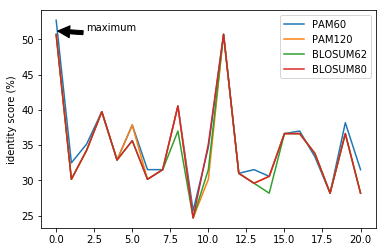

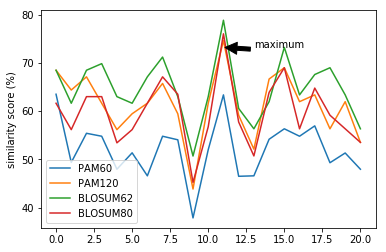

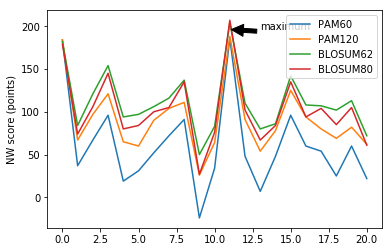

The most similar sequences based on the identity score are :
>sp|O60885|75-147
WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV
and
>sp|O60885|368-440
KHAAYAWPFYKPVDVEALGLHDYCDIIKHPMDMSTIKSKLEAREYRDAQEFGADVRLMFSNCYKYNPPDHEVV

The most similar sequences based on the similarity score are :
>sp|P21675|1397-1467
RDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGPKHSLT
and
>sp|P21675|1520-1590
MAVPDSWPFHHPVNKKFVPDYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYNGPESQYT

The most similar sequences based on the nw score are :
>sp|P21675|1397-1467
RDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGPKHSLT
and
>sp|P21675|1520-1590
MAVPDSWPFHHPVNKKFVPDYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYNGPESQYT



In [2098]:
#Finding the most similar BRD-sequences 
max_iden = 0; pos_iden = None
max_sim = 0; pos_sim = None
max_nw = 0; pos_nw = None
average = []
for i in range(len(pam60)) :
    average.append(pam60[i][:5])
    average[i].append((pam60[i][5]+pam120[i][5]+blosum62[i][5]+blosum80[i][5])/4)
    if average[i][5] > max_iden :
        max_iden = average[i][5]
        pos_iden = i
    average[i].append((pam60[i][6]+pam120[i][6]+blosum62[i][6]+blosum80[i][6])/4)
    if average[i][6] > max_sim :
        max_sim = average[i][6]
        pos_sim = i
    average[i].append((pam60[i][7]+pam120[i][7]+blosum62[i][7]+blosum80[i][7])/4)
    if average[i][7] > max_nw :
        max_nw = average[i][7]
        pos_nw = i

plt.plot([result[5] for result in pam60], label='PAM60')
plt.plot([result[5] for result in pam120], label='PAM120')
plt.plot([result[5] for result in blosum62], label='BLOSUM62')
plt.plot([result[5] for result in blosum80], label='BLOSUM80')
plt.ylabel('identity score (%)')
plt.legend()
plt.annotate('maximum', xy=(pos_iden, max_iden), xytext=(pos_iden+2, max_iden),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

plt.plot([result[6] for result in pam60], label='PAM60')
plt.plot([result[6] for result in pam120], label='PAM120')
plt.plot([result[6] for result in blosum62], label='BLOSUM62')
plt.plot([result[6] for result in blosum80], label='BLOSUM80')
plt.ylabel('similarity score (%)')
plt.legend()
plt.annotate('maximum', xy=(pos_sim, max_sim), xytext=(pos_sim+2, max_sim),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

plt.plot([result[7] for result in pam60], label='PAM60')
plt.plot([result[7] for result in pam120], label='PAM120')
plt.plot([result[7] for result in blosum62], label='BLOSUM62')
plt.plot([result[7] for result in blosum80], label='BLOSUM80')
plt.ylabel('NW score (points)')
plt.legend()
plt.annotate('maximum', xy=(pos_nw, max_nw), xytext=(pos_nw+2, max_nw),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

print('The most similar sequences based on the identity score are :')
pam60[pos_iden][0].pretty_print()
print('and')
pam60[pos_iden][1].pretty_print()
print()

print('The most similar sequences based on the similarity score are :')
pam60[pos_sim][0].pretty_print()
print('and')
pam60[pos_sim][1].pretty_print()
print()

print('The most similar sequences based on the nw score are :')
pam60[pos_nw][0].pretty_print()
print('and')
pam60[pos_nw][1].pretty_print()
print()

#### Are the two sequences subsequences of the same protein, or do they have a different original protein?

By looking at the graphs presented here we can confirm that the combination of most similar sequences is indeed the 12th combination (considering that they are numbered starting with 1), followed by the first combination, if we are considering as the most important the identity score. Also, by checking the source of the sequence, we can see that both sequences on the position 0 are Bromo-domains of the same protein, *__O60885__*, which is a *chromatin reader protein that recognizes and binds acetylated histones and plays a key role in transmission of epigenetic memory across cell divisions and transcription regulation*, specific to human organism, according to *UNIProt*. Also by checking the same database, we can verify the given positions of the Bromo1 and Bromo2 domains matching, as seen in the picture below.


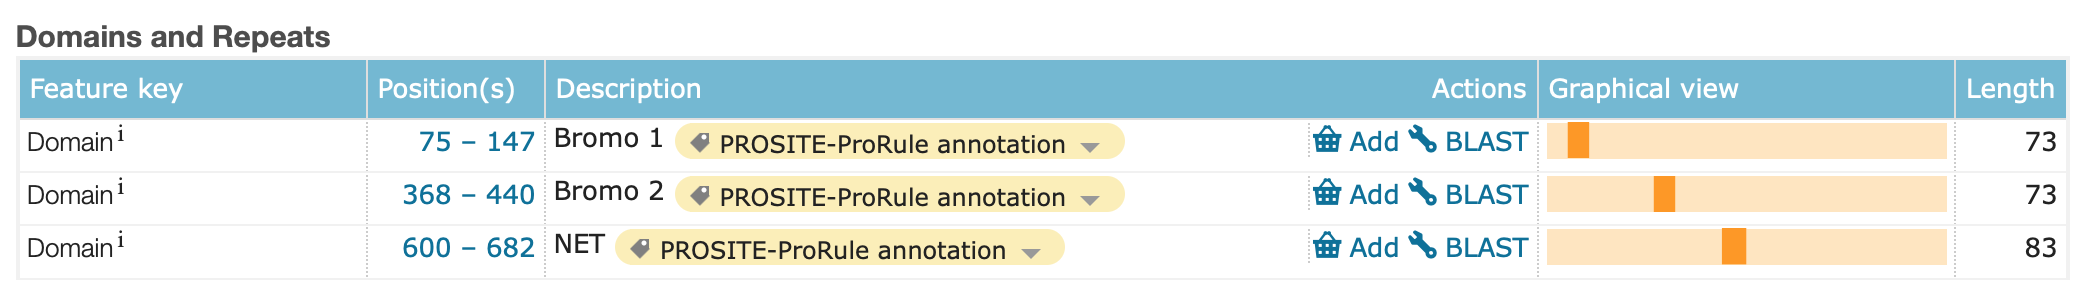

In [2099]:
Image("O60885-domains.png")

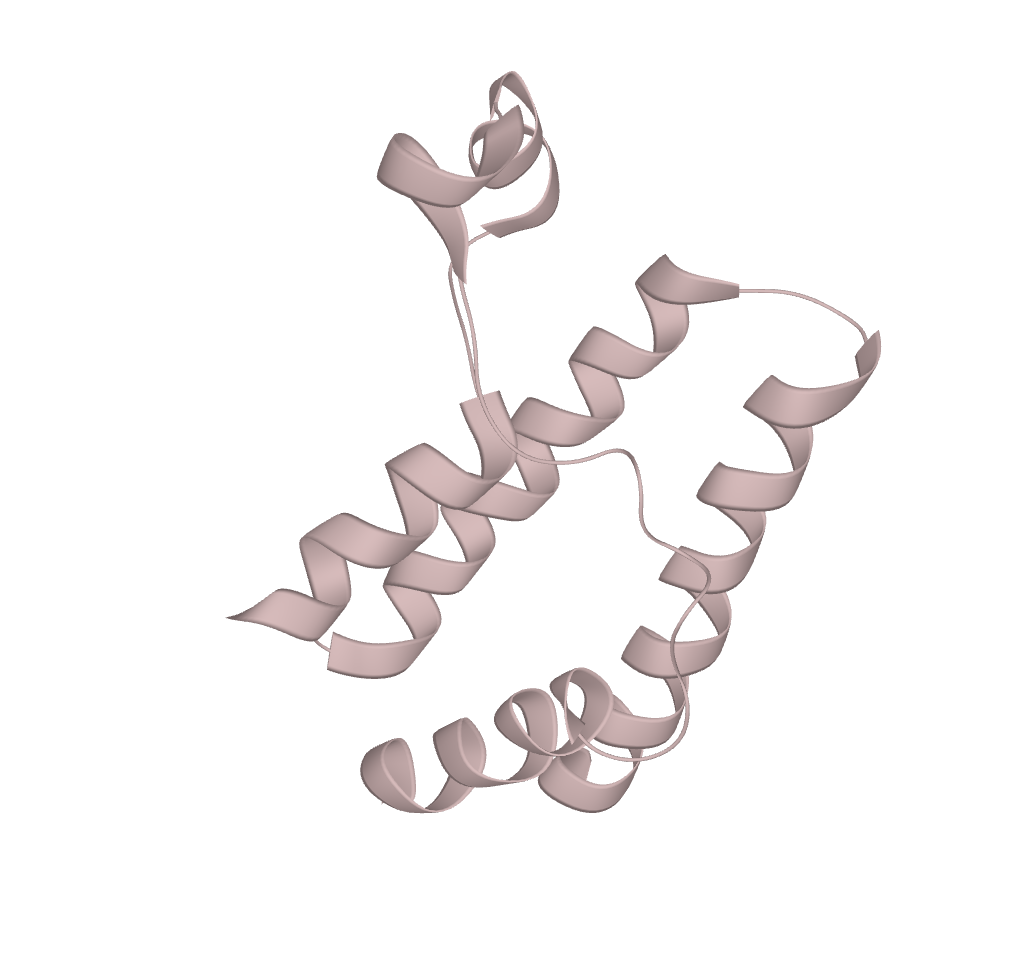

In [2100]:
Image("O60885.png")

Studying now the 12th combination of sequences, which are most similar if we take into account the *similarity score* and the *Needleman-Wunsch score*, we can also deduce that these sequences are part of the same protein, which is __P21675__. According to *UNIProt*, this is the *largest component and core scaffold of the TFIID basal transcription factor complex*. We can also notice, using *UNIProt*, the presence of the two Bromo domains, same as previously, which were aligned by our algoritm, giving a high score.

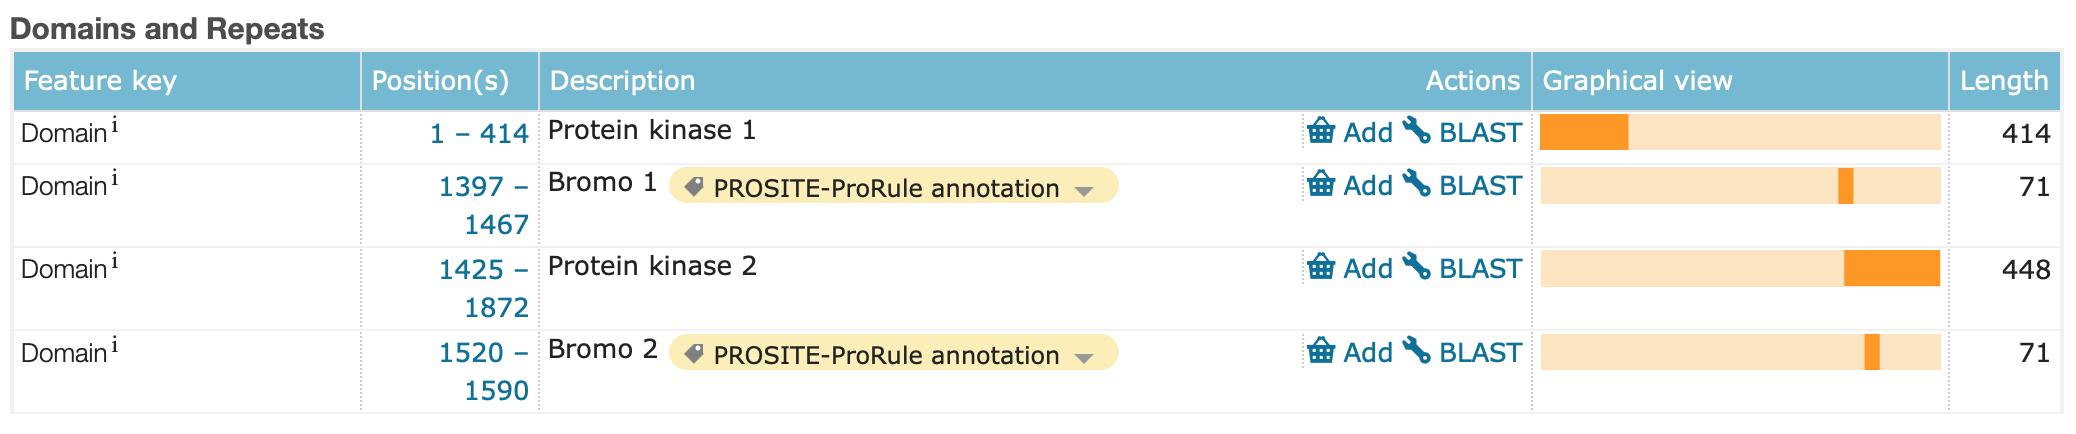

In [2101]:
Image("P21675-domains.png")

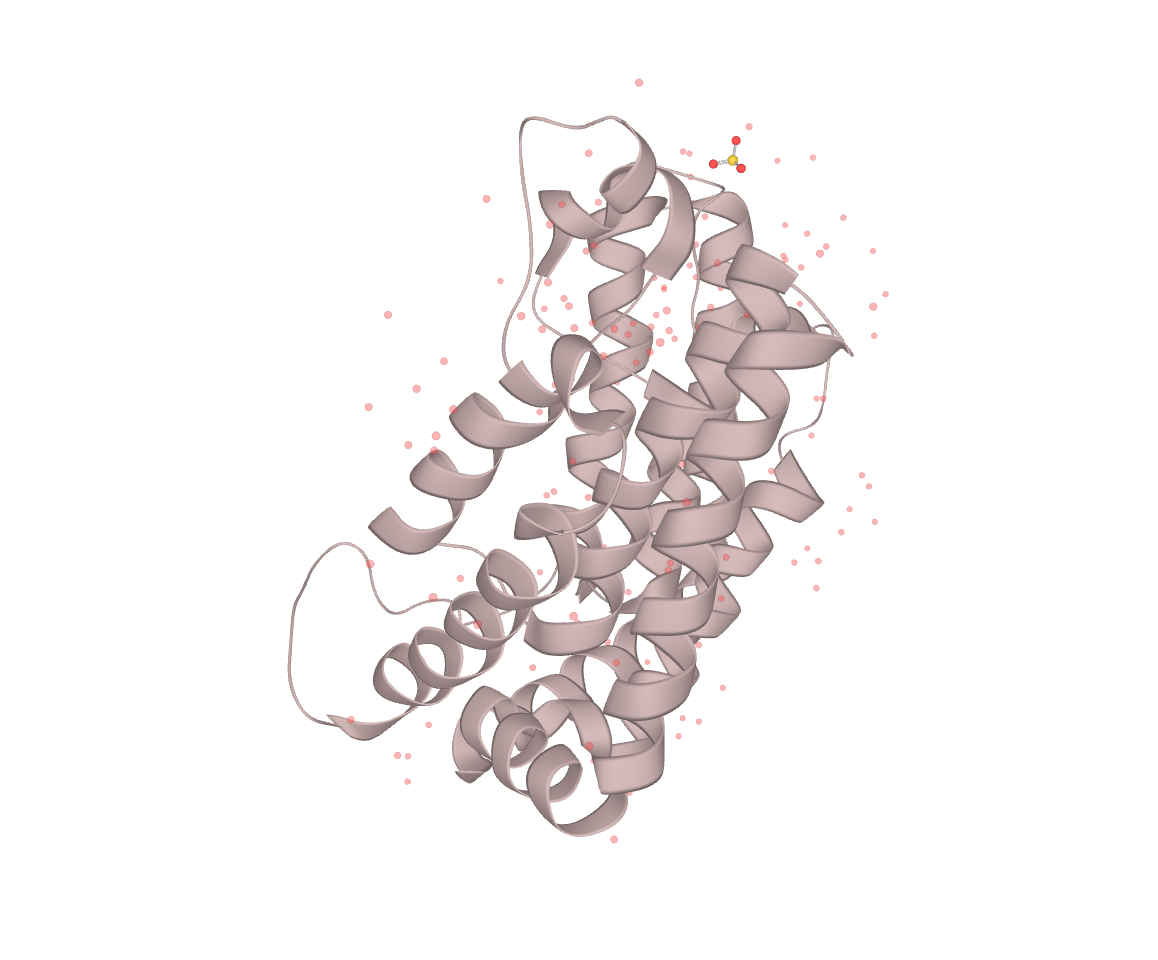

In [2102]:
Image("P21675.png")

Also, just by regarding the two representations of the proteins with the naked, we can notice similar parts in the tridimensional structure, which is the result of the quaternary sructure of the protein and the fact that domains fold independently of the other parts of the protein.

We are now going to compare the protein sequences given for this project. Taking into cosideration their highl variable size and the absence of any information about any similarity, we are going to apply a local alignment. In order not to extend the computation time, we are only going to use the optimal local alignment. As we already mentioned multiple times throughout this paper, preferable for doing this king of alignment is a BLOSUM type substitution matrix and since we don't really know the similarity percentage between the two protein sequences we are going to use firstly the BLOSUM80, which allows up to 80% similarity, and then the more restricting BLOSUM62.

In [ ]:
penalty = [12,2]
blosum80 = []
blosum62 = []

for comb in it.combinations(sequence_dict['protein-sequences'], 2) :
    temp = Score_Matrix(comb[0], comb[1], penalty, matrix_dict['blosum80'])
    temp.local_alignment(1)
    blosum80.append([comb[0],comb[1]] + temp.get_optimal_result())
    del temp
    temp = Score_Matrix(comb[0], comb[1], penalty, matrix_dict['blosum62'])
    temp.local_alignment(1)
    blosum62.append([comb[0],comb[1]] + temp.get_optimal_result())
    del temp    

In [ ]:
#Finding the most similar BRD-sequences 
max_iden = 0; pos_iden = None
max_sim = 0; pos_sim = None
max_nw = 0; pos_nw = None
average = []
for i in range(len(blosum80)) :
    average.append(blosum80[i][:5])
    average[i].append((blosum62[i][5]+blosum80[i][5])/4)
    if average[i][5] > max_iden :
        max_iden = average[i][5]
        pos_iden = i
    average[i].append((blosum62[i][6]+blosum80[i][6])/4)
    if average[i][6] > max_sim :
        max_sim = average[i][6]
        pos_sim = i
    average[i].append((blosum62[i][7]+blosum80[i][7])/4)
    if average[i][7] > max_nw :
        max_nw = average[i][7]
        pos_nw = i
        

plt.plot([result[5] for result in blosum62], label='BLOSUM62')
plt.plot([result[5] for result in blosum80], label='BLOSUM80')
plt.ylabel('identity score (%)')
plt.legend()
plt.annotate('maximum', xy=(pos_iden, max_iden), xytext=(pos_iden+2, max_iden),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()


plt.plot([result[6] for result in blosum62], label='BLOSUM62')
plt.plot([result[6] for result in blosum80], label='BLOSUM80')
plt.ylabel('similarity score (%)')
plt.legend()
plt.annotate('maximum', xy=(pos_sim, max_sim), xytext=(pos_sim+2, max_sim),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()


plt.plot([result[7] for result in blosum62], label='BLOSUM62')
plt.plot([result[7] for result in blosum80], label='BLOSUM80')
plt.ylabel('NW score (points)')
plt.legend()
plt.annotate('maximum', xy=(pos_nw, max_nw), xytext=(pos_nw+2, max_nw),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

print('The most similar sequences based on the identity score are :')
pam60[pos_iden][0].pretty_print()
print('and')
pam60[pos_iden][1].pretty_print()
print()

print('The most similar sequences based on the similarity score are :')
pam60[pos_sim][0].pretty_print()
print('and')
pam60[pos_sim][1].pretty_print()
print()

print('The most similar sequences based on the nw score are :')
pam60[pos_nw][0].pretty_print()
print('and')
pam60[pos_nw][1].pretty_print()
print()